# Solving problems by Searching

This notebook serves as supporting material for topics covered in **Chapter 3 - Solving Problems by Searching** and **Chapter 4 - Beyond Classical Search** from the book *Artificial Intelligence: A Modern Approach.* This notebook uses implementations from [search.py](https://github.com/aimacode/aima-python/blob/master/search.py) module. Let's start by importing everything from search module.

In [1]:
from search import *
from notebook import psource, heatmap, gaussian_kernel, show_map, final_path_colors, display_visual, plot_NQueens

# Needed to hide warnings in the matplotlib sections
import warnings
warnings.filterwarnings("ignore")

## CONTENTS

* Overview
* Problem
* Node
* Simple Problem Solving Agent
* Search Algorithms Visualization
* Breadth-First Tree Search
* Breadth-First Search
* Best First Search
* Uniform Cost Search
* Greedy Best First Search
* A\* Search
* Hill Climbing
* Simulated Annealing
* Genetic Algorithm
* AND-OR Graph Search
* Online DFS Agent
* LRTA* Agent

## OVERVIEW

Here, we learn about a specific kind of problem solving - building goal-based agents that can plan ahead to solve problems. In particular, we examine navigation problem/route finding problem. We must begin by precisely defining **problems** and their **solutions**. We will look at several general-purpose search algorithms.

Search algorithms can be classified into two types:

* **Uninformed search algorithms**: Search algorithms which explore the search space without having any information about the problem other than its definition.
    * Examples:
        1. Breadth First Search
        2. Depth First Search
        3. Depth Limited Search
        4. Iterative Deepening Search


* **Informed search algorithms**: These type of algorithms leverage any information (heuristics, path cost) on the problem to search through the search space to find the solution efficiently.
    * Examples:
        1. Best First Search
        2. Uniform Cost Search
        3. A\* Search
        4. Recursive Best First Search

*Don't miss the visualisations of these algorithms solving the route-finding problem defined on Romania map at the end of this notebook.*

For visualisations, we use networkx and matplotlib to show the map in the notebook and we use ipywidgets to interact with the map to see how the searching algorithm works. These are imported as required in `notebook.py`.

In [2]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import lines

from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
import time

## PROBLEM

Let's see how we define a Problem. Run the next cell to see how abstract class `Problem` is defined in the search module.

In [3]:
psource(Problem)

The `Problem` class has six methods.

* `__init__(self, initial, goal)` : This is what is called a `constructor`. It is the first method called when you create an instance of the class as `Problem(initial, goal)`. The variable `initial` specifies the initial state $s_0$ of the search problem. It represents the beginning state. From here, our agent begins its task of exploration to find the goal state(s) which is given in the `goal` parameter.


* `actions(self, state)` : This method returns all the possible actions agent can execute in the given state `state`.


* `result(self, state, action)` : This returns the resulting state if action `action` is taken in the state `state`. This `Problem` class only deals with deterministic outcomes. So we know for sure what every action in a state would result to.


* `goal_test(self, state)` : Return a boolean for a given state - `True` if it is a goal state, else `False`.


* `path_cost(self, c, state1, action, state2)` : Return the cost of the path that arrives at `state2` as a result of taking `action` from `state1`, assuming total cost of `c` to get up to `state1`.


* `value(self, state)` : This acts as a bit of extra information in problems where we try to optimise a value when we cannot do a goal test.

## NODE

Let's see how we define a Node. Run the next cell to see how abstract class `Node` is defined in the search module.

In [4]:
psource(Node)

The `Node` class has nine methods. The first is the `__init__` method.

* `__init__(self, state, parent, action, path_cost)` : This method creates a node. `parent` represents the node that this is a successor of and `action` is the action required to get from the parent node to this node. `path_cost` is the cost to reach current node from parent node.

The next 4 methods are specific `Node`-related functions.

* `expand(self, problem)` : This method lists all the neighbouring(reachable in one step) nodes of current node. 

* `child_node(self, problem, action)` : Given an `action`, this method returns the immediate neighbour that can be reached with that `action`.

* `solution(self)` : This returns the sequence of actions required to reach this node from the root node. 

* `path(self)` : This returns a list of all the nodes that lies in the path from the root to this node.

The remaining 4 methods override standards Python functionality for representing an object as a string, the less-than ($<$) operator, the equal-to ($=$) operator, and the `hash` function.

* `__repr__(self)` : This returns the state of this node.

* `__lt__(self, node)` : Given a `node`, this method returns `True` if the state of current node is less than the state of the `node`. Otherwise it returns `False`.

* `__eq__(self, other)` : This method returns `True` if the state of current node is equal to the other node. Else it returns `False`.

* `__hash__(self)` : This returns the hash of the state of current node.

We will use the abstract class `Problem` to define our real **problem** named `GraphProblem`. You can see how we define `GraphProblem` by running the next cell.

In [5]:
psource(GraphProblem)

Have a look at our romania_map, which is an Undirected Graph containing a dict of nodes as keys and neighbours as values.

In [6]:
romania_map = UndirectedGraph(dict(
    Arad=dict(Zerind=75, Sibiu=140, Timisoara=118),
    Bucharest=dict(Urziceni=85, Pitesti=101, Giurgiu=90, Fagaras=211),
    Craiova=dict(Drobeta=120, Rimnicu=146, Pitesti=138),
    Drobeta=dict(Mehadia=75),
    Eforie=dict(Hirsova=86),
    Fagaras=dict(Sibiu=99),
    Hirsova=dict(Urziceni=98),
    Iasi=dict(Vaslui=92, Neamt=87),
    Lugoj=dict(Timisoara=111, Mehadia=70),
    Oradea=dict(Zerind=71, Sibiu=151),
    Pitesti=dict(Rimnicu=97),
    Rimnicu=dict(Sibiu=80),
    Urziceni=dict(Vaslui=142)))

romania_map.locations = dict(
    Arad=(91, 492), Bucharest=(400, 327), Craiova=(253, 288),
    Drobeta=(165, 299), Eforie=(562, 293), Fagaras=(305, 449),
    Giurgiu=(375, 270), Hirsova=(534, 350), Iasi=(473, 506),
    Lugoj=(165, 379), Mehadia=(168, 339), Neamt=(406, 537),
    Oradea=(131, 571), Pitesti=(320, 368), Rimnicu=(233, 410),
    Sibiu=(207, 457), Timisoara=(94, 410), Urziceni=(456, 350),
    Vaslui=(509, 444), Zerind=(108, 531))

It is pretty straightforward to understand this `romania_map`. The first node **Arad** has three neighbours named **Zerind**, **Sibiu**, **Timisoara**. Each of these nodes are 75, 140, 118 units apart from **Arad** respectively. And the same goes with other nodes.

And `romania_map.locations` contains the positions of each of the nodes. We will use the straight line distance (which is different from the one provided in `romania_map`) between two cities in algorithms like A\*-search and Recursive Best First Search.

**Define a problem:**
Now it's time to define our problem. We will define it by passing `initial`, `goal`, `graph` to `GraphProblem`. So, our problem is to find the goal state starting from the given initial state on the provided graph. 

Say we want to start exploring from **Arad** and try to find **Bucharest** in our romania_map. So, this is how we do it.

In [7]:
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)

### Romania Map Visualisation

Let's have a visualisation of Romania map [Figure 3.2] from the book and see how different searching algorithms perform / how frontier expands in each search algorithm for a simple problem named `romania_problem`.

Have a look at `romania_locations`. It is a dictionary defined in search module. We will use these location values to draw the romania graph using **networkx**.

In [8]:
romania_locations = romania_map.locations
print(romania_locations)

{'Arad': (91, 492), 'Bucharest': (400, 327), 'Craiova': (253, 288), 'Drobeta': (165, 299), 'Eforie': (562, 293), 'Fagaras': (305, 449), 'Giurgiu': (375, 270), 'Hirsova': (534, 350), 'Iasi': (473, 506), 'Lugoj': (165, 379), 'Mehadia': (168, 339), 'Neamt': (406, 537), 'Oradea': (131, 571), 'Pitesti': (320, 368), 'Rimnicu': (233, 410), 'Sibiu': (207, 457), 'Timisoara': (94, 410), 'Urziceni': (456, 350), 'Vaslui': (509, 444), 'Zerind': (108, 531)}


Let's get started by initializing an empty graph. We will add nodes, place the nodes in their location as shown in the book, add edges to the graph.

In [9]:
# node colors, node positions and node label positions
node_colors = {node: 'white' for node in romania_map.locations.keys()}
node_positions = romania_map.locations
node_label_pos = { k:[v[0],v[1]-10]  for k,v in romania_map.locations.items() }
edge_weights = {(k, k2) : v2 for k, v in romania_map.graph_dict.items() for k2, v2 in v.items()}

romania_graph_data = {  'graph_dict' : romania_map.graph_dict,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                         'edge_weights': edge_weights
                     }

We have completed building our graph based on romania_map and its locations. It's time to display it here in the notebook. This function `show_map(node_colors)` helps us do that. We will be calling this function later on to display the map at each and every interval step while searching, using variety of algorithms from the book.

We can simply call the function with node_colors dictionary object to display it.

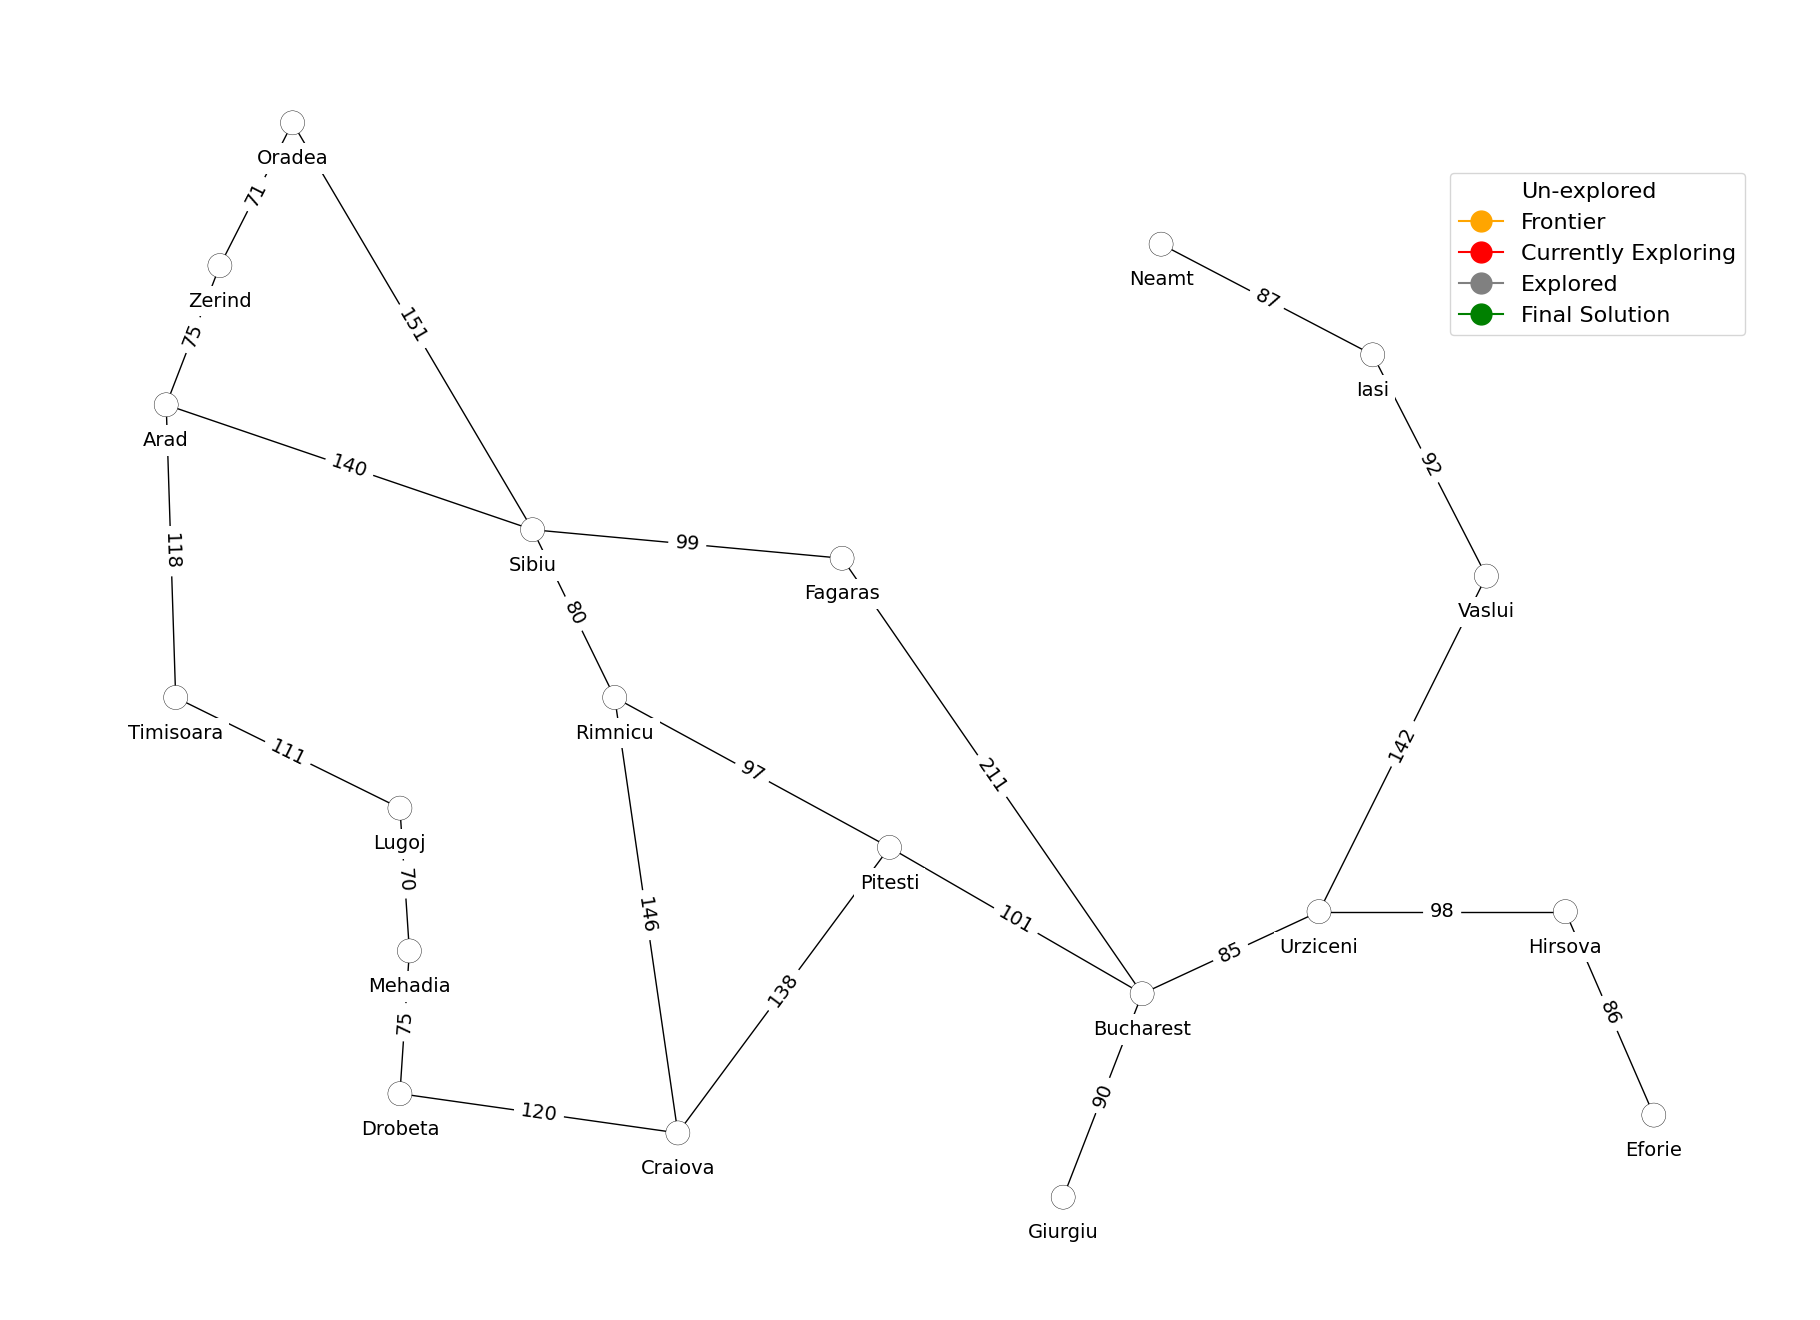

In [10]:
show_map(romania_graph_data)

Voila! You see, the romania map as shown in the Figure[3.2] in the book. Now, see how different searching algorithms perform with our problem statements.

## SIMPLE PROBLEM SOLVING AGENT PROGRAM

Let us now define a Simple Problem Solving Agent Program. Run the next cell to see how the abstract class `SimpleProblemSolvingAgentProgram` is defined in the search module.

In [11]:
psource(SimpleProblemSolvingAgentProgram)

The SimpleProblemSolvingAgentProgram class has six methods:  

* `__init__(self, intial_state=None)`: This is the `contructor` of the class and is the first method to be called when the class is instantiated. It takes in a keyword argument, `initial_state` which is initially `None`. The argument `initial_state` represents the state from which the agent starts.

* `__call__(self, percept)`: This method updates the `state` of the agent based on its `percept` using the `update_state` method. It then formulates a `goal` with the help of `formulate_goal` method and a `problem` using the `formulate_problem` method and returns a sequence of actions to solve it (using the `search` method).

* `update_state(self, percept)`: This method updates the `state` of the agent based on its `percept`.

* `formulate_goal(self, state)`: Given a `state` of the agent, this method formulates the `goal` for it.

* `formulate_problem(self, state, goal)`: It is used in problem formulation given a `state` and a `goal` for the `agent`.

* `search(self, problem)`: This method is used to search a sequence of `actions` to solve a `problem`.

Let us now define a Simple Problem Solving Agent Program. We will create a simple `vacuumAgent` class which will inherit from the abstract class `SimpleProblemSolvingAgentProgram` and overrides its methods. We will create a simple intelligent vacuum agent which can be in any one of the following states. It will move to any other state depending upon the current state as shown in the picture by arrows:

![simple problem solving agent](images/simple_problem_solving_agent.jpg)

In [13]:
class vacuumAgent(SimpleProblemSolvingAgentProgram):
        def update_state(self, state, percept):
            return percept

        def formulate_goal(self, state):
            goal = [state7, state8]
            return goal  

        def formulate_problem(self, state, goal):
            problem = state
            return problem   
    
        def search(self, problem):
            if problem == state1:
                seq = ["Suck", "Right", "Suck"]
            elif problem == state2:
                seq = ["Suck", "Left", "Suck"]
            elif problem == state3:
                seq = ["Right", "Suck"]
            elif problem == state4:
                seq = ["Suck"]
            elif problem == state5:
                seq = ["Suck"]
            elif problem == state6:
                seq = ["Left", "Suck"]
            return seq

Now, we will define all the 8 states and create an object of the above class. Then, we will pass it different states and check the output:

In [14]:
state1 = [(0, 0), [(0, 0), "Dirty"], [(1, 0), ["Dirty"]]]
state2 = [(1, 0), [(0, 0), "Dirty"], [(1, 0), ["Dirty"]]]
state3 = [(0, 0), [(0, 0), "Clean"], [(1, 0), ["Dirty"]]]
state4 = [(1, 0), [(0, 0), "Clean"], [(1, 0), ["Dirty"]]]
state5 = [(0, 0), [(0, 0), "Dirty"], [(1, 0), ["Clean"]]]
state6 = [(1, 0), [(0, 0), "Dirty"], [(1, 0), ["Clean"]]]
state7 = [(0, 0), [(0, 0), "Clean"], [(1, 0), ["Clean"]]]
state8 = [(1, 0), [(0, 0), "Clean"], [(1, 0), ["Clean"]]]

a = vacuumAgent(state1)

print(a(state6)) 
print(a(state1))
print(a(state3))

Left
Suck
Right


## SEARCHING ALGORITHMS VISUALIZATION

In this section, we have visualizations of the following searching algorithms:

1. Breadth First Tree Search
2. Depth First Tree Search
3. Breadth First Search
4. Depth First Graph Search
5. Best First Graph Search
6. Uniform Cost Search
7. Depth Limited Search
8. Iterative Deepening Search
9. Greedy Best First Search
9. A\*-Search
10. Recursive Best First Search

We add the colors to the nodes to have a nice visualisation when displaying. So, these are the different colors we are using in these visuals:
* Un-explored nodes - <font color='black'>white</font>
* Frontier nodes - <font color='orange'>orange</font>
* Currently exploring node - <font color='red'>red</font>
* Already explored nodes - <font color='gray'>gray</font>

## 1. BREADTH-FIRST TREE SEARCH

We have a working implementation in search module. But as we want to interact with the graph while it is searching, we need to modify the implementation. Here's the modified breadth first tree search.

In [18]:
def tree_breadth_search_for_vis(problem):
    """Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Don't worry about repeated paths to a state. [Figure 3.7]"""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    #Adding first node to the queue
    frontier = deque([Node(problem.initial)])
    
    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    while frontier:
        #Popping first node of queue
        node = frontier.popleft()
        
        # modify the currently searching node to red
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            # modify goal node to green after reaching the goal
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        frontier.extend(node.expand(problem))
           
        for n in node.expand(problem):
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))

        # modify the color of explored nodes to gray
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
    return None

def breadth_first_tree_search(problem):
    "Search the shallowest nodes in the search tree first."
    iterations, all_node_colors, node = tree_breadth_search_for_vis(problem)
    return(iterations, all_node_colors, node)

Now, we use `ipywidgets` to display a slider, a button and our romania map. By sliding the slider we can have a look at all the intermediate steps of a particular search algorithm. By pressing the button **Visualize**, you can see all the steps without interacting with the slider. These two helper functions are the callback functions which are called when we interact with the slider and the button.

In [19]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
a, b, c = breadth_first_tree_search(romania_problem)
display_visual(romania_graph_data, user_input=False, 
               algorithm=breadth_first_tree_search, 
               problem=romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 2. DEPTH-FIRST TREE SEARCH
Now let's discuss another searching algorithm, Depth-First Tree Search.

In [20]:
def tree_depth_search_for_vis(problem):
    """Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Don't worry about repeated paths to a state. [Figure 3.7]"""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    #Adding first node to the stack
    frontier = [Node(problem.initial)]
    
    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    while frontier:
        #Popping first node of stack
        node = frontier.pop()
        
        # modify the currently searching node to red
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            # modify goal node to green after reaching the goal
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        frontier.extend(node.expand(problem))
           
        for n in node.expand(problem):
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))

        # modify the color of explored nodes to gray
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
    return None

def depth_first_tree_search(problem):
    "Search the deepest nodes in the search tree first."
    iterations, all_node_colors, node = tree_depth_search_for_vis(problem)
    return(iterations, all_node_colors, node)

In [21]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input=False, 
               algorithm=depth_first_tree_search, 
               problem=romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 3. BREADTH-FIRST GRAPH SEARCH

Let's change all the `node_colors` to starting position and define a different problem statement.

In [18]:
def breadth_first_search_graph(problem):
    "[Figure 3.11]"
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    node = Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
      
    if problem.goal_test(node.state):
        node_colors[node.state] = "green"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    frontier = deque([node])
    
    # modify the color of frontier nodes to blue
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
        
    explored = set()
    while frontier:
        node = frontier.popleft()
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        explored.add(node.state)     
        
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                if problem.goal_test(child.state):
                    node_colors[child.state] = "green"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))
                    return(iterations, all_node_colors, child)
                frontier.append(child)

                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
                    
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

In [ ]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input=False, 
               algorithm=breadth_first_search_graph, 
               problem=romania_problem)

## 4. DEPTH-FIRST GRAPH SEARCH 
Although we have a working implementation in search module, we have to make a few changes in the algorithm to make it suitable for visualization.

In [20]:
def graph_search_for_vis(problem):
    """Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    If two paths reach a state, only use the first one. [Figure 3.7]"""
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    frontier = [(Node(problem.initial))]
    explored = set()
    
    # modify the color of frontier nodes to orange
    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
      
    while frontier:
        # Popping first node of stack
        node = frontier.pop()
        
        # modify the currently searching node to red
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            # modify goal node to green after reaching the goal
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        explored.add(node.state)
        frontier.extend(child for child in node.expand(problem)
                        if child.state not in explored and
                        child not in frontier)
        
        for n in frontier:
            # modify the color of frontier nodes to orange
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))

        # modify the color of explored nodes to gray
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
    return None


def depth_first_graph_search(problem):
    """Search the deepest nodes in the search tree first."""
    iterations, all_node_colors, node = graph_search_for_vis(problem)
    return(iterations, all_node_colors, node)

In [ ]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input=False, 
               algorithm=depth_first_graph_search, 
               problem=romania_problem)

## 5. BEST FIRST SEARCH

Let's change all the `node_colors` to starting position and define a different problem statement.

In [22]:
def best_first_graph_search_for_vis(problem, f):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned."""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    f = memoize(f, 'f')
    node = Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    if problem.goal_test(node.state):
        node_colors[node.state] = "green"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    frontier = PriorityQueue('min', f)
    frontier.append(node)
    
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    explored = set()
    while frontier:
        node = frontier.pop()
        
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
            elif child in frontier:
                incumbent = frontier[child]
                if f(child) < incumbent:
                    del frontier[child]
                    frontier.append(child)
                    node_colors[child.state] = "orange"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))

        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

## 6. UNIFORM COST SEARCH

Let's change all the `node_colors` to starting position and define a different problem statement.

In [23]:
def uniform_cost_search_graph(problem):
    "[Figure 3.14]"
    #Uniform Cost Search uses Best First Search algorithm with f(n) = g(n)
    iterations, all_node_colors, node = best_first_graph_search_for_vis(problem, lambda node: node.path_cost)
    return(iterations, all_node_colors, node)


In [ ]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input=False, 
               algorithm=uniform_cost_search_graph, 
               problem=romania_problem)

## 7. DEPTH LIMITED SEARCH

Let's change all the 'node_colors' to starting position and define a different problem statement.  
Although we have a working implementation, but we need to make changes.

In [25]:
def depth_limited_search_graph(problem, limit = -1):
    '''
    Perform depth first search of graph g.
    if limit >= 0, that is the maximum depth of the search.
    '''
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    frontier = [Node(problem.initial)]
    explored = set()
    
    cutoff_occurred = False
    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
      
    while frontier:
        # Popping first node of queue
        node = frontier.pop()
        
        # modify the currently searching node to red
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            # modify goal node to green after reaching the goal
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)

        elif limit >= 0:
            cutoff_occurred = True
            limit += 1
            all_node_colors.pop()
            iterations -= 1
            node_colors[node.state] = "gray"

        
        explored.add(node.state)
        frontier.extend(child for child in node.expand(problem)
                        if child.state not in explored and
                        child not in frontier)
        
        for n in frontier:
            limit -= 1
            # modify the color of frontier nodes to orange
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))

        # modify the color of explored nodes to gray
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
    return 'cutoff' if cutoff_occurred else None


def depth_limited_search_for_vis(problem):
    """Search the deepest nodes in the search tree first."""
    iterations, all_node_colors, node = depth_limited_search_graph(problem)
    return(iterations, all_node_colors, node)     

In [ ]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input=False, 
               algorithm=depth_limited_search_for_vis, 
               problem=romania_problem)

## 8. ITERATIVE DEEPENING SEARCH

Let's change all the 'node_colors' to starting position and define a different problem statement.  

In [27]:
def iterative_deepening_search_for_vis(problem):
    for depth in range(sys.maxsize):
        iterations, all_node_colors, node=depth_limited_search_for_vis(problem)
        if iterations:
            return (iterations, all_node_colors, node)

In [ ]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input=False, 
               algorithm=iterative_deepening_search_for_vis, 
               problem=romania_problem)

## 9. GREEDY BEST FIRST SEARCH
Let's change all the node_colors to starting position and define a different problem statement.

In [29]:
def greedy_best_first_search(problem, h=None):
    """Greedy Best-first graph search is an informative searching algorithm with f(n) = h(n).
    You need to specify the h function when you call best_first_search, or
    else in your Problem subclass."""
    h = memoize(h or problem.h, 'h')
    iterations, all_node_colors, node = best_first_graph_search_for_vis(problem, lambda n: h(n))
    return(iterations, all_node_colors, node)


In [ ]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input=False, 
               algorithm=greedy_best_first_search, 
               problem=romania_problem)

## 10. A\* SEARCH

Let's change all the `node_colors` to starting position and define a different problem statement.

In [31]:
def astar_search_graph(problem, h=None):
    """A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass."""
    h = memoize(h or problem.h, 'h')
    iterations, all_node_colors, node = best_first_graph_search_for_vis(problem, 
                                                                lambda n: n.path_cost + h(n))
    return(iterations, all_node_colors, node)


In [ ]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input=False, 
               algorithm=astar_search_graph, 
               problem=romania_problem)

## 11. RECURSIVE BEST FIRST SEARCH
Let's change all the `node_colors` to starting position and define a different problem statement.

In [33]:
def recursive_best_first_search_for_vis(problem, h=None):
    """[Figure 3.26] Recursive best-first search"""
    # we use these two variables at the time of visualizations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    h = memoize(h or problem.h, 'h')
    
    def RBFS(problem, node, flimit):
        nonlocal iterations
        def color_city_and_update_map(node, color):
            node_colors[node.state] = color
            nonlocal iterations
            iterations += 1
            all_node_colors.append(dict(node_colors))
            
        if problem.goal_test(node.state):
            color_city_and_update_map(node, 'green')
            return (iterations, all_node_colors, node), 0  # the second value is immaterial
        
        successors = node.expand(problem)
        if len(successors) == 0:
            color_city_and_update_map(node, 'gray')
            return (iterations, all_node_colors, None), infinity
        
        for s in successors:
            color_city_and_update_map(s, 'orange')
            s.f = max(s.path_cost + h(s), node.f)
            
        while True:
            # Order by lowest f value
            successors.sort(key=lambda x: x.f)
            best = successors[0]
            if best.f > flimit:
                color_city_and_update_map(node, 'gray')
                return (iterations, all_node_colors, None), best.f
            
            if len(successors) > 1:
                alternative = successors[1].f
            else:
                alternative = infinity
                
            node_colors[node.state] = 'gray'
            node_colors[best.state] = 'red'
            iterations += 1
            all_node_colors.append(dict(node_colors))
            result, best.f = RBFS(problem, best, min(flimit, alternative))
            if result[2] is not None:
                color_city_and_update_map(node, 'green')
                return result, best.f
            else:
                color_city_and_update_map(node, 'red')
                
    node = Node(problem.initial)
    node.f = h(node)
    
    node_colors[node.state] = 'red'
    iterations += 1
    all_node_colors.append(dict(node_colors))
    result, bestf = RBFS(problem, node, infinity)
    return result

In [ ]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input=False,
               algorithm=recursive_best_first_search_for_vis,
               problem=romania_problem)

In [ ]:
all_node_colors = []
# display_visual(romania_graph_data, user_input=True, algorithm=breadth_first_tree_search)
algorithms = {  "Breadth First Tree Search": tree_breadth_search_for_vis,
                "Depth First Tree Search": tree_depth_search_for_vis,
                "Breadth First Search": breadth_first_search_graph,
                "Depth First Graph Search": graph_search_for_vis,
                "Best First Graph Search": best_first_graph_search_for_vis,
                "Uniform Cost Search": uniform_cost_search_graph,
                "Depth Limited Search": depth_limited_search_for_vis,
                "Iterative Deepening Search": iterative_deepening_search_for_vis,
                "Greedy Best First Search": greedy_best_first_search,
                "A-star Search": astar_search_graph,
                "Recursive Best First Search": recursive_best_first_search_for_vis}
display_visual(romania_graph_data, algorithm=algorithms, user_input=True)

## RECURSIVE BEST-FIRST SEARCH
Recursive best-first search is a simple recursive algorithm that improves upon heuristic search by reducing the memory requirement.
RBFS uses only linear space and it attempts to mimic the operation of standard best-first search.
Its structure is similar to recursive depth-first search but it doesn't continue indefinitely down the current path, the `f_limit` variable is used to keep track of the f-value of the best _alternative_ path available from any ancestor of the current node.
RBFS remembers the f-value of the best leaf in the forgotten subtree and can decide whether it is worth re-expanding the tree later.
<br>
However, RBFS still suffers from excessive node regeneration.
<br>
Let's have a look at the implementation.

In [36]:
psource(recursive_best_first_search)

This is how `recursive_best_first_search` can solve the `romania_problem`

In [37]:
recursive_best_first_search(romania_problem).solution()

['Sibiu', 'Rimnicu', 'Pitesti', 'Bucharest']

`recursive_best_first_search` can be used to solve the 8 puzzle problem too, as discussed later.

In [38]:
puzzle = EightPuzzle((2, 4, 3, 1, 5, 6, 7, 8, 0))
assert puzzle.check_solvability((2, 4, 3, 1, 5, 6, 7, 8, 0))
recursive_best_first_search(puzzle).solution()

['UP', 'LEFT', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'RIGHT', 'DOWN']

## A* HEURISTICS

Different heuristics provide different efficiency in solving A* problems which are generally defined by the number of explored nodes as well as the branching factor. With the classic 8 puzzle we can show the efficiency of different heuristics through the number of explored nodes.

### 8 Puzzle Problem

The *8 Puzzle Problem* consists of a 3x3 tray in which the goal is to get the initial configuration to the goal state by shifting the numbered tiles into the blank space.

example:- 

              Initial State                        Goal State
              | 7 | 2 | 4 |                       | 1 | 2 | 3 |
              | 5 | 0 | 6 |                       | 4 | 5 | 6 |
              | 8 | 3 | 1 |                       | 7 | 8 | 0 |
              
We have a total of 9 blank tiles giving us a total of 9! initial configuration but not all of these are solvable. The solvability of a configuration can be checked by calculating the Inversion Permutation. If the total Inversion Permutation is even then the initial configuration is solvable else the initial configuration is not solvable which means that only 9!/2 initial states lead to a solution.
<br>
Let's define our goal state.

In [39]:
goal = [1, 2, 3, 4, 5, 6, 7, 8, 0]

#### Heuristics :-

1) Manhattan Distance:- For the 8 puzzle problem Manhattan distance is defined as the distance of a tile from its goal state( for the tile numbered '1' in the initial configuration Manhattan distance is 4 "2 for left and 2 for upward displacement").

2) No. of Misplaced Tiles:- The heuristic calculates the number of misplaced tiles between the current state and goal state.

3) Sqrt of Manhattan Distance:- It calculates the square root of Manhattan distance.

4) Max Heuristic:- It assign the score as the maximum between "Manhattan Distance" and "No. of Misplaced Tiles".

In [40]:
# Heuristics for 8 Puzzle Problem
import math

def linear(node):
    return sum([1 if node.state[i] != goal[i] else 0 for i in range(8)])

def manhattan(node):
    state = node.state
    index_goal = {0:[2,2], 1:[0,0], 2:[0,1], 3:[0,2], 4:[1,0], 5:[1,1], 6:[1,2], 7:[2,0], 8:[2,1]}
    index_state = {}
    index = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2]]
    x, y = 0, 0
    
    for i in range(len(state)):
        index_state[state[i]] = index[i]
    
    mhd = 0
    
    for i in range(8):
        for j in range(2):
            mhd = abs(index_goal[i][j] - index_state[i][j]) + mhd
    
    return mhd

def sqrt_manhattan(node):
    state = node.state
    index_goal = {0:[2,2], 1:[0,0], 2:[0,1], 3:[0,2], 4:[1,0], 5:[1,1], 6:[1,2], 7:[2,0], 8:[2,1]}
    index_state = {}
    index = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2]]
    x, y = 0, 0
    
    for i in range(len(state)):
        index_state[state[i]] = index[i]
    
    mhd = 0
    
    for i in range(8):
        for j in range(2):
            mhd = (index_goal[i][j] - index_state[i][j])**2 + mhd
    
    return math.sqrt(mhd)

def max_heuristic(node):
    score1 = manhattan(node)
    score2 = linear(node)
    return max(score1, score2)

We can solve the puzzle using the `astar_search` method.

In [41]:
# Solving the puzzle 
puzzle = EightPuzzle((2, 4, 3, 1, 5, 6, 7, 8, 0))
puzzle.check_solvability((2, 4, 3, 1, 5, 6, 7, 8, 0)) # checks whether the initialized configuration is solvable or not

True

This case is solvable, let's proceed.
<br>
The default heuristic function returns the number of misplaced tiles.

In [42]:
astar_search(puzzle).solution()

['UP', 'LEFT', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'RIGHT', 'DOWN']

In the following cells, we use different heuristic functions.
<br>

In [43]:
astar_search(puzzle, linear).solution()

['UP', 'LEFT', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'RIGHT', 'DOWN']

In [44]:
astar_search(puzzle, manhattan).solution()

['LEFT', 'UP', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'DOWN', 'RIGHT']

In [45]:
astar_search(puzzle, sqrt_manhattan).solution()

['LEFT', 'UP', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'DOWN', 'RIGHT']

In [46]:
astar_search(puzzle, max_heuristic).solution()

['LEFT', 'UP', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'DOWN', 'RIGHT']

And here's how `recursive_best_first_search` can be used to solve this problem too.

In [47]:
recursive_best_first_search(puzzle, manhattan).solution()

['LEFT', 'UP', 'UP', 'LEFT', 'DOWN', 'RIGHT', 'DOWN', 'UP', 'DOWN', 'RIGHT']

Even though all the heuristic functions give the same solution, the difference lies in the computation time.
<br>
This might make all the difference in a scenario where high computational efficiency is required.
<br>
Let's define a few puzzle states and time `astar_search` for every heuristic function.
We will use the %%timeit magic for this.

In [48]:
puzzle_1 = EightPuzzle((2, 4, 3, 1, 5, 6, 7, 8, 0))
puzzle_2 = EightPuzzle((1, 2, 3, 4, 5, 6, 0, 7, 8))
puzzle_3 = EightPuzzle((1, 2, 3, 4, 5, 7, 8, 6, 0))

The default heuristic function is the same as the `linear` heuristic function, but we'll still check both.

In [49]:
%%timeit
astar_search(puzzle_1)
astar_search(puzzle_2)
astar_search(puzzle_3)

3.24 ms ± 190 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [50]:
%%timeit
astar_search(puzzle_1, linear)
astar_search(puzzle_2, linear)
astar_search(puzzle_3, linear)

3.68 ms ± 368 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [51]:
%%timeit
astar_search(puzzle_1, manhattan)
astar_search(puzzle_2, manhattan)
astar_search(puzzle_3, manhattan)

3.12 ms ± 88.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [52]:
%%timeit
astar_search(puzzle_1, sqrt_manhattan)
astar_search(puzzle_2, sqrt_manhattan)
astar_search(puzzle_3, sqrt_manhattan)

22.7 ms ± 1.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [53]:
%%timeit
astar_search(puzzle_1, max_heuristic)
astar_search(puzzle_2, max_heuristic)
astar_search(puzzle_3, max_heuristic)

3.91 ms ± 434 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We can infer that the `manhattan` heuristic function works the fastest.
<br>
`sqrt_manhattan` has an extra `sqrt` operation which makes it quite a lot slower than the others.
<br>
`max_heuristic` should have been a bit slower as it calls two functions, but in this case, those values were already calculated which saved some time.
Feel free to play around with these functions.

For comparison, this is how RBFS performs on this problem.

In [54]:
%%timeit
recursive_best_first_search(puzzle_1, linear)
recursive_best_first_search(puzzle_2, linear)
recursive_best_first_search(puzzle_3, linear)

140 ms ± 9.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


It is quite a lot slower than `astar_search` as we can see.

## HILL CLIMBING

Hill Climbing is a heuristic search used for optimization problems.
Given a large set of inputs and a good heuristic function, it tries to find a sufficiently good solution to the problem. 
This solution may or may not be the global optimum.
The algorithm is a variant of generate and test algorithm. 
<br>
As a whole, the algorithm works as follows:
- Evaluate the initial state.
- If it is equal to the goal state, return.
- Find a neighboring state (one which is heuristically similar to the current state)
- Evaluate this state. If it is closer to the goal state than before, replace the initial state with this state and repeat these steps.
<br>

In [55]:
psource(hill_climbing)

We will find an approximate solution to the traveling salespersons problem using this algorithm.
<br>
We need to define a class for this problem.
<br>
`Problem` will be used as a base class.

In [56]:
class TSP_problem(Problem):

    """ subclass of Problem to define various functions """

    def two_opt(self, state):
        """ Neighbour generating function for Traveling Salesman Problem """
        neighbour_state = state[:]
        left = random.randint(0, len(neighbour_state) - 1)
        right = random.randint(0, len(neighbour_state) - 1)
        if left > right:
            left, right = right, left
        neighbour_state[left: right + 1] = reversed(neighbour_state[left: right + 1])
        return neighbour_state

    def actions(self, state):
        """ action that can be excuted in given state """
        return [self.two_opt]

    def result(self, state, action):
        """  result after applying the given action on the given state """
        return action(state)

    def path_cost(self, c, state1, action, state2):
        """ total distance for the Traveling Salesman to be covered if in state2  """
        cost = 0
        for i in range(len(state2) - 1):
            cost += distances[state2[i]][state2[i + 1]]
        cost += distances[state2[0]][state2[-1]]
        return cost

    def value(self, state):
        """ value of path cost given negative for the given state """
        return -1 * self.path_cost(None, None, None, state)

We will use cities from the Romania map as our cities for this problem.
<br>
A list of all cities and a dictionary storing distances between them will be populated.

In [57]:
distances = {}
all_cities = []

for city in romania_map.locations.keys():
    distances[city] = {}
    all_cities.append(city)
    
all_cities.sort()
print(all_cities)

['Arad', 'Bucharest', 'Craiova', 'Drobeta', 'Eforie', 'Fagaras', 'Giurgiu', 'Hirsova', 'Iasi', 'Lugoj', 'Mehadia', 'Neamt', 'Oradea', 'Pitesti', 'Rimnicu', 'Sibiu', 'Timisoara', 'Urziceni', 'Vaslui', 'Zerind']


Next, we need to populate the individual lists inside the dictionary with the manhattan distance between the cities.

In [58]:
import numpy as np
for name_1, coordinates_1 in romania_map.locations.items():
        for name_2, coordinates_2 in romania_map.locations.items():
            distances[name_1][name_2] = np.linalg.norm(
                [coordinates_1[0] - coordinates_2[0], coordinates_1[1] - coordinates_2[1]])
            distances[name_2][name_1] = np.linalg.norm(
                [coordinates_1[0] - coordinates_2[0], coordinates_1[1] - coordinates_2[1]])

The way neighbours are chosen currently isn't suitable for the travelling salespersons problem.
We need a neighboring state that is similar in total path distance to the current state.
<br>
We need to change the function that finds neighbors.

In [59]:
def hill_climbing(problem):
    
    """From the initial node, keep choosing the neighbor with highest value,
    stopping when no neighbor is better. [Figure 4.2]"""
    
    def find_neighbors(state, number_of_neighbors=100):
        """ finds neighbors using two_opt method """
        
        neighbors = []
        
        for i in range(number_of_neighbors):
            new_state = problem.two_opt(state)
            neighbors.append(Node(new_state))
            state = new_state
            
        return neighbors

    # as this is a stochastic algorithm, we will set a cap on the number of iterations
    iterations = 10000
    
    current = Node(problem.initial)
    while iterations:
        neighbors = find_neighbors(current.state)
        if not neighbors:
            break
        neighbor = argmax_random_tie(neighbors,
                                     key=lambda node: problem.value(node.state))
        if problem.value(neighbor.state) <= problem.value(current.state):
           """Note that it is based on negative path cost method"""
            current.state = neighbor.state
        iterations -= 1
        
    return current.state

An instance of the TSP_problem class will be created.

In [60]:
tsp = TSP_problem(all_cities)

We can now generate an approximate solution to the problem by calling `hill_climbing`.
The results will vary a bit each time you run it.

In [50]:
hill_climbing(tsp)

['Arad',
 'Timisoara',
 'Lugoj',
 'Mehadia',
 'Drobeta',
 'Craiova',
 'Pitesti',
 'Giurgiu',
 'Bucharest',
 'Urziceni',
 'Eforie',
 'Hirsova',
 'Vaslui',
 'Iasi',
 'Neamt',
 'Fagaras',
 'Rimnicu',
 'Sibiu',
 'Oradea',
 'Zerind']

The solution looks like this.
It is not difficult to see why this might be a good solution.
<br>
![title](images/hillclimb-tsp.png)

## SIMULATED ANNEALING

The intuition behind Hill Climbing was developed from the metaphor of climbing up the graph of a function to find its peak. 
There is a fundamental problem in the implementation of the algorithm however.
To find the highest hill, we take one step at a time, always uphill, hoping to find the highest point, 
but if we are unlucky to start from the shoulder of the second-highest hill, there is no way we can find the highest one. 
The algorithm will always converge to the local optimum.
Hill Climbing is also bad at dealing with functions that flatline in certain regions.
If all neighboring states have the same value, we cannot find the global optimum using this algorithm.
<br>
<br>
Let's now look at an algorithm that can deal with these situations.
<br>
Simulated Annealing is quite similar to Hill Climbing, 
but instead of picking the _best_ move every iteration, it picks a _random_ move. 
If this random move brings us closer to the global optimum, it will be accepted, 
but if it doesn't, the algorithm may accept or reject the move based on a probability dictated by the _temperature_. 
When the `temperature` is high, the algorithm is more likely to accept a random move even if it is bad.
At low temperatures, only good moves are accepted, with the occasional exception.
This allows exploration of the state space and prevents the algorithm from getting stuck at the local optimum.


In [62]:
psource(simulated_annealing)

The temperature is gradually decreased over the course of the iteration.
This is done by a scheduling routine.
The current implementation uses exponential decay of temperature, but we can use a different scheduling routine instead.


In [63]:
psource(exp_schedule)

Next, we'll define a peak-finding problem and try to solve it using Simulated Annealing.
Let's define the grid and the initial state first.


In [64]:
initial = (0, 0)
grid = [[3, 7, 2, 8], [5, 2, 9, 1], [5, 3, 3, 1]]

We want to allow only four directions, namely `N`, `S`, `E` and `W`.
Let's use the predefined `directions4` dictionary.

In [65]:
directions4

{'E': (1, 0), 'N': (0, 1), 'S': (0, -1), 'W': (-1, 0)}

Define a problem with these parameters.

In [66]:
problem = PeakFindingProblem(initial, grid, directions4)

We'll run `simulated_annealing` a few times and store the solutions in a set.

In [67]:
solutions = {problem.value(simulated_annealing(problem)) for i in range(100)}

In [68]:
max(solutions)

9

Hence, the maximum value is 9.

Let's find the peak of a two-dimensional gaussian distribution.
We'll use the `gaussian_kernel` function from notebook.py to get the distribution.

In [69]:
grid = gaussian_kernel()

Let's use the `heatmap` function from notebook.py to plot this.

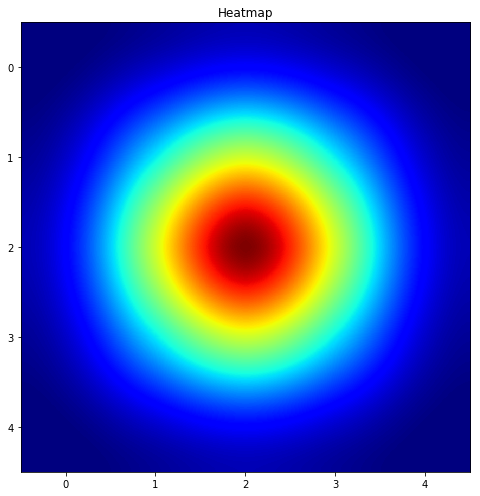

In [70]:
heatmap(grid, cmap='jet', interpolation='spline16')

Let's define the problem.
This time, we will allow movement in eight directions as defined in `directions8`.

In [71]:
directions8

{'E': (1, 0),
 'N': (0, 1),
 'NE': (1, 1),
 'NW': (-1, 1),
 'S': (0, -1),
 'SE': (1, -1),
 'SW': (-1, -1),
 'W': (-1, 0)}

We'll solve the problem just like we did last time.
<br>
Let's also time it.

In [72]:
problem = PeakFindingProblem(initial, grid, directions8)

In [13]:
%%timeit
solutions = {problem.value(simulated_annealing(problem)) for i in range(100)}

533 ms ± 51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
max(solutions)

9

The peak is at 1.0 which is how gaussian distributions are defined.
<br>
This could also be solved by Hill Climbing as follows.

In [15]:
%%timeit
solution = problem.value(hill_climbing(problem))

206 µs ± 21.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
solution = problem.value(hill_climbing(problem))
solution

1.0

As you can see, Hill-Climbing is about 24 times faster than Simulated Annealing.
(Notice that we ran Simulated Annealing for 100 iterations whereas we ran Hill Climbing only once.)
<br>
Simulated Annealing makes up for its tardiness by its ability to be applicable in a larger number of scenarios than Hill Climbing as illustrated by the example below.
<br>

Let's define a 2D surface as a matrix.

In [73]:
grid = [[0, 0, 0, 1, 4], 
        [0, 0, 2, 8, 10], 
        [0, 0, 2, 4, 12], 
        [0, 2, 4, 8, 16], 
        [1, 4, 8, 16, 32]]

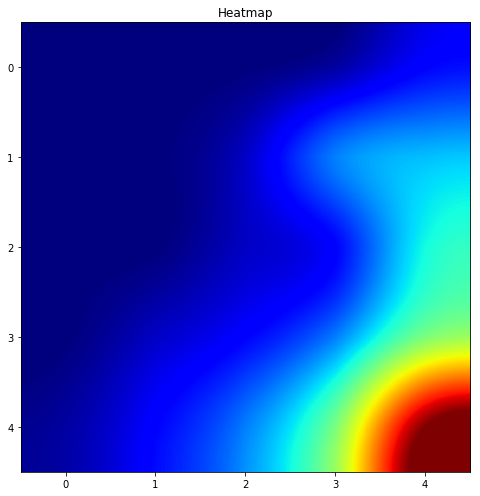

In [74]:
heatmap(grid, cmap='jet', interpolation='spline16')

The peak value is 32 at the lower right corner.
<br>
The region at the upper left corner is planar.

Let's instantiate `PeakFindingProblem` one last time.

In [75]:
problem = PeakFindingProblem(initial, grid, directions8)

Solution by Hill Climbing

In [20]:
solution = problem.value(hill_climbing(problem))

In [21]:
solution

0

Solution by Simulated Annealing

In [22]:
solutions = {problem.value(simulated_annealing(problem)) for i in range(100)}
max(solutions)

32

Notice that even though both algorithms started at the same initial state, 
Hill Climbing could never escape from the planar region and gave a locally optimum solution of **0**,
whereas Simulated Annealing could reach the peak at **32**.
<br>
A very similar situation arises when there are two peaks of different heights.
One should carefully consider the possible search space before choosing the algorithm for the task.

## GENETIC ALGORITHM

Genetic algorithms (or GA) are inspired by natural evolution and are particularly useful in optimization and search problems with large state spaces.

Given a problem, algorithms in the domain make use of a *population* of solutions (also called *states*), where each solution/state represents a feasible solution. At each iteration (often called *generation*), the population gets updated using methods inspired by biology and evolution, like *crossover*, *mutation* and *natural selection*.

### Overview

A genetic algorithm works in the following way:

1) Initialize random population.

2) Calculate population fitness.

3) Select individuals for mating.

4) Mate selected individuals to produce new population.

     * Random chance to mutate individuals.

5) Repeat from step 2) until an individual is fit enough or the maximum number of iterations is reached.

### Glossary

Before we continue, we will lay the basic terminology of the algorithm.

* Individual/State: A list of elements (called *genes*) that represent possible solutions.

* Population: The list of all the individuals/states.

* Gene pool: The alphabet of possible values for an individual's genes.

* Generation/Iteration: The number of times the population will be updated.

* Fitness: An individual's score, calculated by a function specific to the problem.

### Crossover

Two individuals/states can "mate" and produce one child. This offspring bears characteristics from both of its parents. There are many ways we can implement this crossover. Here we will take a look at the most common ones. Most other methods are variations of those below.

* Point Crossover: The crossover occurs around one (or more) point. The parents get "split" at the chosen point or points and then get merged. In the example below we see two parents get split and merged at the 3rd digit, producing the following offspring after the crossover.

![point crossover](images/point_crossover.png)

* Uniform Crossover: This type of crossover chooses randomly the genes to get merged. Here the genes 1, 2 and 5 were chosen from the first parent, so the genes 3, 4 were added by the second parent.

![uniform crossover](images/uniform_crossover.png)

### Mutation

When an offspring is produced, there is a chance it will mutate, having one (or more, depending on the implementation) of its genes altered.

For example, let's say the new individual to undergo mutation is "abcde". Randomly we pick to change its third gene to 'z'. The individual now becomes "abzde" and is added to the population.

### Selection

At each iteration, the fittest individuals are picked randomly to mate and produce offsprings. We measure an individual's fitness with a *fitness function*. That function depends on the given problem and it is used to score an individual. Usually the higher the better.

The selection process is this:

1) Individuals are scored by the fitness function.

2) Individuals are picked randomly, according to their score (higher score means higher chance to get picked). Usually the formula to calculate the chance to pick an individual is the following (for population *P* and individual *i*):

$$ chance(i) = \dfrac{fitness(i)}{\sum_{k \, in \, P}{fitness(k)}} $$

### Implementation

Below we look over the implementation of the algorithm in the `search` module.

First the implementation of the main core of the algorithm:

In [51]:
psource(genetic_algorithm)

The algorithm takes the following input:

* `population`: The initial population.

* `fitness_fn`: The problem's fitness function.

* `gene_pool`: The gene pool of the states/individuals. By default 0 and 1.

* `f_thres`: The fitness threshold. If an individual reaches that score, iteration stops. By default 'None', which means the algorithm will not halt until the generations are ran.

* `ngen`: The number of iterations/generations.

* `pmut`: The probability of mutation.

The algorithm gives as output the state with the largest score.

For each generation, the algorithm updates the population. First it calculates the fitnesses of the individuals, then it selects the most fit ones and finally crosses them over to produce offsprings. There is a chance that the offspring will be mutated, given by `pmut`. If at the end of the generation an individual meets the fitness threshold, the algorithm halts and returns that individual.

The function of mating is accomplished by the method `recombine`:

In [52]:
psource(recombine)

The method picks at random a point and merges the parents (`x` and `y`) around it.

The mutation is done in the method `mutate`:

In [53]:
psource(mutate)

We pick a gene in `x` to mutate and a gene from the gene pool to replace it with.

To help initializing the population we have the helper function `init_population`:

In [54]:
psource(init_population)

The function takes as input the number of individuals in the population, the gene pool and the length of each individual/state. It creates individuals with random genes and returns the population when done.

### Explanation

Before we solve problems using the genetic algorithm, we will explain how to intuitively understand the algorithm using a trivial example.

#### Generating Phrases

In this problem, we use a genetic algorithm to generate a particular target phrase from a population of random strings. This is a classic example that helps build intuition about how to use this algorithm in other problems as well. Before we break the problem down, let us try to brute force the solution. Let us say that we want to generate the phrase "genetic algorithm". The phrase is 17 characters long. We can use any character from the 26 lowercase characters and the space character. To generate a random phrase of length 17, each space can be filled in 27 ways. So the total number of possible phrases is

$$ 27^{17} = 2153693963075557766310747 $$

which is a massive number. If we wanted to generate the phrase "Genetic Algorithm", we would also have to include all the 26 uppercase characters into consideration thereby increasing the sample space from 27 characters to 53 characters and the total number of possible phrases then would be

$$ 53^{17} = 205442259656281392806087233013 $$

If we wanted to include punctuations and numerals into the sample space, we would have further complicated an already impossible problem. Hence, brute forcing is not an option. Now we'll apply the genetic algorithm and see how it significantly reduces the search space. We essentially want to *evolve* our population of random strings so that they better approximate the target phrase as the number of generations increase. Genetic algorithms work on the principle of Darwinian Natural Selection according to which, there are three key concepts that need to be in place for evolution to happen. They are:

* **Heredity**: There must be a process in place by which children receive the properties of their parents. <br> 
For this particular problem, two strings from the population will be chosen as parents and will be split at a random index and recombined as described in the `recombine` function to create a child. This child string will then be added to the new generation.


* **Variation**: There must be a variety of traits present in the population or a means with which to introduce variation. <br>If there is no variation in the sample space, we might never reach the global optimum. To ensure that there is enough variation, we can initialize a large population, but this gets computationally expensive as the population gets larger. Hence, we often use another method called mutation. In this method, we randomly change one or more characters of some strings in the population based on a predefined probability value called the mutation rate or mutation probability as described in the `mutate` function. The mutation rate is usually kept quite low. A mutation rate of zero fails to introduce variation in the population and a high mutation rate (say 50%) is as good as a coin flip and the population fails to benefit from the previous recombinations. An optimum balance has to be maintained between population size and mutation rate so as to reduce the computational cost as well as have sufficient variation in the population.


* **Selection**: There must be some mechanism by which some members of the population have the opportunity to be parents and pass down their genetic information and some do not. This is typically referred to as "survival of the fittest". <br>
There has to be some way of determining which phrases in our population have a better chance of eventually evolving into the target phrase. This is done by introducing a fitness function that calculates how close the generated phrase is to the target phrase. The function will simply return a scalar value corresponding to the number of matching characters between the generated phrase and the target phrase.

Before solving the problem, we first need to define our target phrase.

In [55]:
target = 'Genetic Algorithm'

We then need to define our gene pool, i.e the elements which an individual from the population might comprise of. Here, the gene pool contains all uppercase and lowercase letters of the English alphabet and the space character.

In [56]:
# The ASCII values of uppercase characters ranges from 65 to 91
u_case = [chr(x) for x in range(65, 91)]
# The ASCII values of lowercase characters ranges from 97 to 123
l_case = [chr(x) for x in range(97, 123)]

gene_pool = []
gene_pool.extend(u_case) # adds the uppercase list to the gene pool
gene_pool.extend(l_case) # adds the lowercase list to the gene pool
gene_pool.append(' ')    # adds the space character to the gene pool

We now need to define the maximum size of each population. Larger populations have more variation but are computationally more  expensive to run algorithms on.

In [57]:
max_population = 100

As our population is not very large, we can afford to keep a relatively large mutation rate.

In [58]:
mutation_rate = 0.07 # 7%

Great! Now, we need to define the most important metric for the genetic algorithm, i.e the fitness function. This will simply return the number of matching characters between the generated sample and the target phrase.

In [59]:
def fitness_fn(sample):
    # initialize fitness to 0
    fitness = 0
    for i in range(len(sample)):
        # increment fitness by 1 for every matching character
        if sample[i] == target[i]:
            fitness += 1
    return fitness

Before we run our genetic algorithm, we need to initialize a random population. We will use the `init_population` function to do this. We need to pass in the maximum population size, the gene pool and the length of each individual, which in this case will be the same as the length of the target phrase.

In [60]:
population = init_population(max_population, gene_pool, len(target))

We will now define how the individuals in the population should change as the number of generations increases. First, the `select` function will be run on the population to select *two* individuals with high fitness values. These will be the parents which will then be recombined using the `recombine` function to generate the child.

In [61]:
parents = select(2, population, fitness_fn) 

In [62]:
# The recombine function takes two parents as arguments, so we need to unpack the previous variable
child = recombine(*parents)

Next, we need to apply a mutation according to the mutation rate. We call the `mutate` function on the child with the gene pool and mutation rate as the additional arguments.

In [63]:
child = mutate(child, gene_pool, mutation_rate)

The above lines can be condensed into

`child = mutate(recombine(*select(2, population, fitness_fn)), gene_pool, mutation_rate)`

And, we need to do this `for` every individual in the current population to generate the new population.

In [64]:
population = [mutate(recombine(*select(2, population, fitness_fn)), gene_pool, mutation_rate) for i in range(len(population))]

The individual with the highest fitness can then be found using the `max` function.

In [65]:
current_best = max(population, key=fitness_fn)

Let's print this out

In [66]:
print(current_best)

['J', 'y', 'O', 'e', ' ', 'h', 'c', 'r', 'C', 'W', 'H', 'o', 'r', 'R', 'y', 'P', 'U']


We see that this is a list of characters. This can be converted to a string using the join function

In [67]:
current_best_string = ''.join(current_best)
print(current_best_string)

JyOe hcrCWHorRyPU


We now need to define the conditions to terminate the algorithm. This can happen in two ways
1. Termination after a predefined number of generations
2. Termination when the fitness of the best individual of the current generation reaches a predefined threshold value.

We define these variables below

In [68]:
ngen = 1200 # maximum number of generations
# we set the threshold fitness equal to the length of the target phrase
# i.e the algorithm only terminates whne it has got all the characters correct 
# or it has completed 'ngen' number of generations
f_thres = len(target)

To generate `ngen` number of generations, we run a `for` loop `ngen` number of times. After each generation, we calculate the fitness of the best individual of the generation and compare it to the value of `f_thres` using the `fitness_threshold` function. After every generation, we print out the best individual of the generation and the corresponding fitness value. Lets now write a function to do this.

In [69]:
def genetic_algorithm_stepwise(population, fitness_fn, gene_pool=[0, 1], f_thres=None, ngen=1200, pmut=0.1):
    for generation in range(ngen):
        population = [mutate(recombine(*select(2, population, fitness_fn)), gene_pool, pmut) for i in range(len(population))]
        # stores the individual genome with the highest fitness in the current population
        current_best = ''.join(max(population, key=fitness_fn))
        print(f'Current best: {current_best}\t\tGeneration: {str(generation)}\t\tFitness: {fitness_fn(current_best)}\r', end='')
        
        # compare the fitness of the current best individual to f_thres
        fittest_individual = fitness_threshold(fitness_fn, f_thres, population)
        
        # if fitness is greater than or equal to f_thres, we terminate the algorithm
        if fittest_individual:
            return fittest_individual, generation
    return max(population, key=fitness_fn) , generation       

The function defined above is essentially the same as the one defined in `search.py` with the added functionality of printing out the data of each generation.

In [70]:
psource(genetic_algorithm)

We have defined all the required functions and variables. Let's now create a new population and test the function we wrote above.

In [71]:
population = init_population(max_population, gene_pool, len(target))
solution, generations = genetic_algorithm_stepwise(population, fitness_fn, gene_pool, f_thres, ngen, mutation_rate)

The genetic algorithm was able to converge!
We implore you to rerun the above cell and play around with `target, max_population, f_thres, ngen` etc parameters to get a better intuition of how the algorithm works. To summarize, if we can define the problem states in simple array format and if we can create a fitness function to gauge how good or bad our approximate solutions are, there is a high chance that we can get a satisfactory solution using a genetic algorithm. 
- There is also a better GUI version of this program `genetic_algorithm_example.py` in the GUI folder for you to play around with.

### Usage

Below we give two example usages for the genetic algorithm, for a graph coloring problem and the 8 queens problem.

#### Graph Coloring

First we will take on the simpler problem of coloring a small graph with two colors. Before we do anything, let's imagine how a solution might look. First, we have to represent our colors. Say, 'R' for red and 'G' for green. These make up our gene pool. What of the individual solutions though? For that, we will look at our problem. We stated we have a graph. A graph has nodes and edges, and we want to color the nodes. Naturally, we want to store each node's color. If we have four nodes, we can store their colors in a list of genes, one for each node. A possible solution will then look like this: ['R', 'R', 'G', 'R']. In the general case, we will represent each solution with a list of chars ('R' and 'G'), with length the number of nodes.

Next we need to come up with a fitness function that appropriately scores individuals. Again, we will look at the problem definition at hand. We want to color a graph. For a solution to be optimal, no edge should connect two nodes of the same color. How can we use this information to score a solution? A naive (and ineffective) approach would be to count the different colors in the string. So ['R', 'R', 'R', 'R'] has a score of 1 and ['R', 'R', 'G', 'G'] has a score of 2. Why that fitness function is not ideal though? Why, we forgot the information about the edges! The edges are pivotal to the problem and the above function only deals with node colors. We didn't use all the information at hand and ended up with an ineffective answer. How, then, can we use that information to our advantage?

We said that the optimal solution will have all the edges connecting nodes of different color. So, to score a solution we can count how many edges are valid (aka connecting nodes of different color). That is a great fitness function!

Let's jump into solving this problem using the `genetic_algorithm` function.

First we need to represent the graph. Since we mostly need information about edges, we will just store the edges. We will denote edges with capital letters and nodes with integers:

In [72]:
edges = {
    'A': [0, 1],
    'B': [0, 3],
    'C': [1, 2],
    'D': [2, 3]
}

Edge 'A' connects nodes 0 and 1, edge 'B' connects nodes 0 and 3 etc.

We already said our gene pool is 'R' and 'G', so we can jump right into initializing our population. Since we have only four nodes, `state_length` should be 4. For the number of individuals, we will try 8. We can increase this number if we need higher accuracy, but be careful! Larger populations need more computating power and take longer. You need to strike that sweet balance between accuracy and cost (the ultimate dilemma of the programmer!).

In [73]:
population = init_population(8, ['R', 'G'], 4)
print(population)

[['R', 'G', 'G', 'G'], ['G', 'R', 'R', 'G'], ['G', 'G', 'G', 'G'], ['G', 'R', 'G', 'G'], ['G', 'G', 'G', 'R'], ['G', 'R', 'R', 'G'], ['G', 'R', 'G', 'G'], ['G', 'G', 'R', 'G']]


We created and printed the population. You can see that the genes in the individuals are random and there are 8 individuals each with 4 genes.

Next we need to write our fitness function. We previously said we want the function to count how many edges are valid. So, given a coloring/individual `c`, we will do just that:

In [74]:
def fitness(c):
    return sum(c[n1] != c[n2] for (n1, n2) in edges.values())

Great! Now we will run the genetic algorithm and see what solution it gives.

In [75]:
solution = genetic_algorithm(population, fitness, gene_pool=['R', 'G'])
print(solution)

['R', 'G', 'R', 'G']


The algorithm converged to a solution. Let's check its score:

In [76]:
print(fitness(solution))

4


The solution has a score of 4. Which means it is optimal, since we have exactly 4 edges in our graph, meaning all are valid!

*NOTE: Because the algorithm is non-deterministic, there is a chance a different solution is given. It might even be wrong, if we are very unlucky!*

#### Eight Queens

Let's take a look at a more complicated problem.

In the *Eight Queens* problem, we are tasked with placing eight queens on an 8x8 chessboard without any queen threatening the others (aka queens should not be in the same row, column or diagonal). In its general form the problem is defined as placing *N* queens in an NxN chessboard without any conflicts.

First we need to think about the representation of each solution. We can go the naive route of representing the whole chessboard with the queens' placements on it. That is definitely one way to go about it, but for the purpose of this tutorial we will do something different. We have eight queens, so we will have a gene for each of them. The gene pool will be numbers from 0 to 7, for the different columns. The *position* of the gene in the state will denote the row the particular queen is placed in.

For example, we can have the state "03304577". Here the first gene with a value of 0 means "the queen at row 0 is placed at column 0", for the second gene "the queen at row 1 is placed at column 3" and so forth.

We now need to think about the fitness function. On the graph coloring problem we counted the valid edges. The same thought process can be applied here. Instead of edges though, we have positioning between queens. If two queens are not threatening each other, we say they are at a "non-attacking" positioning. We can, therefore, count how many such positionings are there.

Let's dive right in and initialize our population:

In [77]:
population = init_population(100, range(8), 8)
print(population[:5])

[[2, 6, 2, 0, 2, 3, 4, 7], [7, 2, 0, 6, 3, 3, 0, 6], [2, 3, 0, 6, 6, 2, 5, 5], [2, 6, 4, 2, 3, 5, 5, 5], [3, 1, 5, 1, 5, 1, 0, 3]]


We have a population of 100 and each individual has 8 genes. The gene pool is the integers from 0 to 7, in string form. Above you can see the first five individuals.

Next we need to write our fitness function. Remember, queens threaten each other if they are at the same row, column or diagonal.

Since positionings are mutual, we must take care not to count them twice. Therefore for each queen, we will only check for conflicts for the queens after her.

A gene's value in an individual `q` denotes the queen's column, and the position of the gene denotes its row. We can check if the aforementioned values between two genes are the same. We also need to check for diagonals. A queen *a* is in the diagonal of another queen, *b*, if the difference of the rows between them is equal to either their difference in columns (for the diagonal on the right of *a*) or equal to the negative difference of their columns (for the left diagonal of *a*). Below is given the fitness function.

In [78]:
def fitness(q):
    non_attacking = 0
    for row1 in range(len(q)):
        for row2 in range(row1+1, len(q)):
            col1 = int(q[row1])
            col2 = int(q[row2])
            row_diff = row1 - row2
            col_diff = col1 - col2

            if col1 != col2 and row_diff != col_diff and row_diff != -col_diff:
                non_attacking += 1

    return non_attacking

Note that the best score achievable is 28. That is because for each queen we only check for the queens after her. For the first queen we check 7 other queens, for the second queen 6 others and so on. In short, the number of checks we make is the sum 7+6+5+...+1. Which is equal to 7\*(7+1)/2 = 28.

Because it is very hard and will take long to find a perfect solution, we will set the fitness threshold at 25. If we find an individual with a score greater or equal to that, we will halt. Let's see how the genetic algorithm will fare.

In [79]:
solution = genetic_algorithm(population, fitness, f_thres=25, gene_pool=range(8))
print(solution)
print(fitness(solution))

[2, 5, 7, 1, 3, 6, 4, 6]
25


Above you can see the solution and its fitness score, which should be no less than 25.

This is where we conclude Genetic Algorithms.

### N-Queens Problem
Here, we will look at the generalized cae of the Eight Queens problem.
<br>
We are given a `N` x `N` chessboard, with `N` queens, and we need to place them in such a way that no two queens can attack each other.
<br>
We will solve this problem using search algorithms.
To do this, we already have a `NQueensProblem` class in `search.py`.

In [80]:
psource(NQueensProblem)

In [`csp.ipynb`](https://github.com/aimacode/aima-python/blob/master/csp.ipynb) we have seen that the N-Queens problem can be formulated as a CSP and can be solved by 
the `min_conflicts` algorithm in a way similar to Hill-Climbing. 
Here, we want to solve it using heuristic search algorithms and even some classical search algorithms.
The `NQueensProblem` class derives from the `Problem` class and is implemented in such a way that the search algorithms we already have, can solve it.
<br>
Let's instantiate the class.

In [81]:
nqp = NQueensProblem(8)

Let's use `depth_first_tree_search` first.
<br>
We will also use the %%timeit magic with each algorithm to see how much time they take.

In [82]:
%%timeit
depth_first_tree_search(nqp)

4.82 ms ± 498 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [83]:
dfts = depth_first_tree_search(nqp).solution()

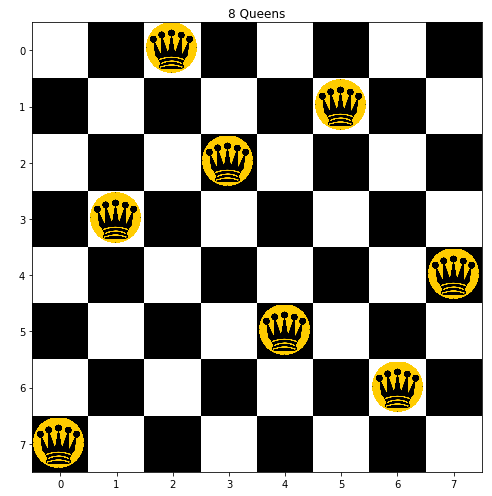

In [84]:
plot_NQueens(dfts)

`breadth_first_tree_search`

In [85]:
%%timeit
breadth_first_tree_search(nqp)

88.6 ms ± 2.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [86]:
bfts = breadth_first_tree_search(nqp).solution()

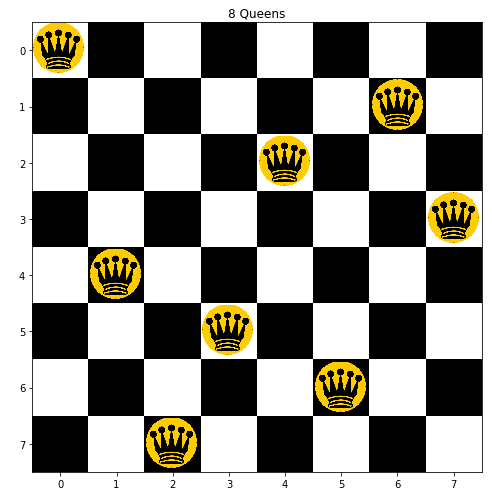

In [87]:
plot_NQueens(bfts)

`uniform_cost_search`

In [88]:
%%timeit
uniform_cost_search(nqp)

1.08 s ± 154 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [89]:
ucs = uniform_cost_search(nqp).solution()

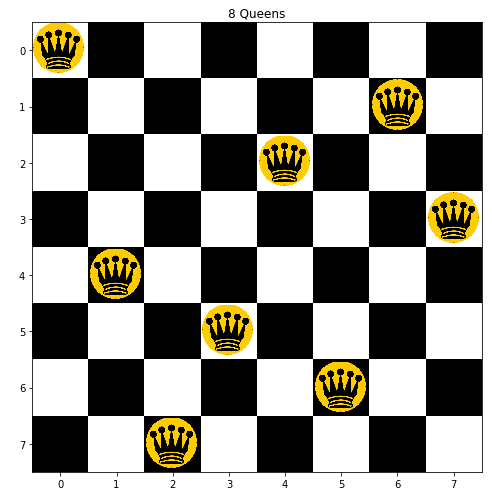

In [90]:
plot_NQueens(ucs)

`depth_first_tree_search` is almost 20 times faster than `breadth_first_tree_search` and more than 200 times faster than `uniform_cost_search`.

We can also solve this problem using `astar_search` with a suitable heuristic function. 
<br>
The best heuristic function for this scenario will be one that returns the number of conflicts in the current state.

In [91]:
psource(NQueensProblem.h)

In [92]:
%%timeit
astar_search(nqp)

8.85 ms ± 424 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


`astar_search` is faster than both `uniform_cost_search` and `breadth_first_tree_search`.

In [93]:
astar = astar_search(nqp).solution()

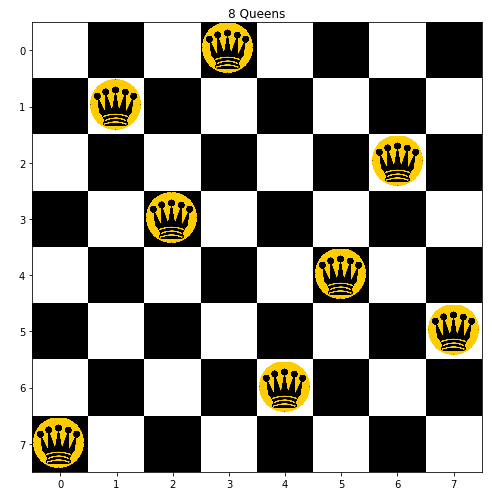

In [94]:
plot_NQueens(astar)

## AND-OR GRAPH SEARCH
An _AND-OR_ graph is a graphical representation of the reduction of goals to _conjunctions_ and _disjunctions_ of subgoals.
<br>
An _AND-OR_ graph can be seen as a generalization of a directed graph.
It contains a number of vertices and generalized edges that connect the vertices.
<br>
Each connector in an _AND-OR_ graph connects a set of vertices $V$ to a single vertex, $v_0$.
A connector can be an _AND_ connector or an _OR_ connector.
An __AND__ connector connects two edges having a logical _AND_ relationship,
while and __OR__ connector connects two edges having a logical _OR_ relationship.
<br>
A vertex can have more than one _AND_ or _OR_ connector.
This is why _AND-OR_ graphs can be expressed as logical statements.
<br>
<br>
_AND-OR_ graphs also provide a computational model for executing logic programs and you will come across this data-structure in the `logic` module as well.
_AND-OR_ graphs can be searched in depth-first, breadth-first or best-first ways searching the state sapce linearly or parallely.
<br>
Our implementation of _AND-OR_ search searches over graphs generated by non-deterministic environments and returns a conditional plan that reaches a goal state in all circumstances.
Let's have a look at the implementation of `and_or_graph_search`.

In [76]:
psource(and_or_graph_search)

The search is carried out by two functions `and_search` and `or_search` that recursively call each other, traversing nodes sequentially.
It is a recursive depth-first algorithm for searching an _AND-OR_ graph.
<br>
A very similar algorithm `fol_bc_ask` can be found in the `logic` module, which carries out inference on first-order logic knowledge bases using _AND-OR_ graph-derived data-structures.
<br>
_AND-OR_ trees can also be used to represent the search spaces for two-player games, where a vertex of the tree represents the problem of one of the players winning the game, starting from the initial state of the game.
<br>
Problems involving _MIN-MAX_ trees can be reformulated as _AND-OR_ trees by representing _MAX_ nodes as _OR_ nodes and _MIN_ nodes as _AND_ nodes.
`and_or_graph_search` can then be used to find the optimal solution.
Standard algorithms like `minimax` and `expectiminimax` (for belief states) can also be applied on it with a few modifications.

Here's how `and_or_graph_search` can be applied to a simple vacuum-world example.

In [77]:
vacuum_world = GraphProblemStochastic('State_1', ['State_7', 'State_8'], vacuum_world)
plan = and_or_graph_search(vacuum_world)

In [78]:
plan

['Suck',
 {'State_5': ['Right', {'State_6': ['Suck', {'State_8': []}]}], 'State_7': []}]

In [79]:
def run_plan(state, problem, plan):
    if problem.goal_test(state):
        return True
    if len(plan) is not 2:
        return False
    predicate = lambda x: run_plan(x, problem, plan[1][x])
    return all(predicate(r) for r in problem.result(state, plan[0]))

In [80]:
run_plan('State_1', vacuum_world, plan)

True

## ONLINE DFS AGENT
So far, we have seen agents that use __offline search__ algorithms,
which is a class of algorithms that compute a complete solution before executing it.
In contrast, an __online search__ agent interleaves computation and action.
Online search is better for most dynamic environments and necessary for unknown environments.
<br>
Online search problems are solved by an agent executing actions, rather than just by pure computation.
For a fully observable environment, an online agent cycles through three steps: taking an action, computing the step cost and checking if the goal has been reached.
<br>
For online algorithms in partially-observable environments, there is usually a tradeoff between exploration and exploitation to be taken care of.
<br>
<br>
Whenever an online agent takes an action, it receives a _percept_ or an observation that tells it something about its immediate environment.
Using this percept, the agent can augment its map of the current environment.
For a partially observable environment, this is called the belief state.
<br>
Online algorithms expand nodes in a _local_ order, just like _depth-first search_ as it does not have the option of observing farther nodes like _A* search_.
Whenever an action from the current state has not been explored, the agent tries that action.
<br>
Difficulty arises when the agent has tried all actions in a particular state.
An offline search algorithm would simply drop the state from the queue in this scenario whereas an online search agent has to physically move back to the previous state.
To do this, the agent needs to maintain a table where it stores the order of nodes it has been to.
This is how our implementation of _Online DFS-Agent_ works.
This agent works only in state spaces where the action is reversible, because of the use of backtracking.
<br>
Let's have a look at the `OnlineDFSAgent` class.

In [81]:
psource(OnlineDFSAgent)

It maintains two dictionaries `untried` and `unbacktracked`.
`untried` contains nodes that have not been visited yet.
`unbacktracked` contains the sequence of nodes that the agent has visited so it can backtrack to it later, if required.
`s` and `a` store the state and the action respectively and `result` stores the final path or solution of the problem.
<br>
Let's look at another online search algorithm.

## LRTA* AGENT
We can infer now that hill-climbing is an online search algorithm, but it is not very useful natively because for complicated search spaces, it might converge to the local minima and indefinitely stay there.
In such a case, we can choose to randomly restart it a few times with different starting conditions and return the result with the lowest total cost.
Sometimes, it is better to use random walks instead of random restarts depending on the problem, but progress can still be very slow.
<br>
A better improvement would be to give hill-climbing a memory element.
We store the current best heuristic estimate and it is updated as the agent gains experience in the state space.
The estimated optimal cost is made more and more accurate as time passes and each time the the local minima is "flattened out" until we escape it.
<br>
This learning scheme is a simple improvement upon traditional hill-climbing and is called _learning real-time A*_ or __LRTA*__.
Similar to _Online DFS-Agent_, it builds a map of the environment and chooses the best possible move according to its current heuristic estimates.
<br>
Actions that haven't been tried yet are assumed to lead immediately to the goal with the least possible cost.
This is called __optimism under uncertainty__ and encourages the agent to explore new promising paths.
This algorithm might not terminate if the state space is infinite, unlike A* search.
<br>
Let's have a look at the `LRTAStarAgent` class.

In [82]:
psource(LRTAStarAgent)

`H` stores the heuristic cost of the paths the agent may travel to.
<br>
`s` and `a` store the state and the action respectively.
<br>
`problem` stores the problem definition and the current map of the environment is stored in `problem.result`.
<br>
The `LRTA_cost` method computes the cost of a new path given the current state `s`, the action `a`, the next state `s1` and the estimated cost to get from `s` to `s1` is extracted from `H`.

Let's use `LRTAStarAgent` to solve a simple problem.
We'll define a new `LRTA_problem` instance based on our `one_dim_state_space`.

In [83]:
one_dim_state_space

Let's define an instance of `OnlineSearchProblem`.

In [84]:
LRTA_problem = OnlineSearchProblem('State_3', 'State_5', one_dim_state_space)

Now we initialize a `LRTAStarAgent` object for the problem we just defined.

In [85]:
lrta_agent = LRTAStarAgent(LRTA_problem)

We'll pass the percepts `[State_3, State_4, State_3, State_4, State_5]` one-by-one to our agent to see what action it comes up with at each timestep.

In [86]:
lrta_agent('State_3')

State_3 Right State_4
State_3 Left State_2


'Right'

In [87]:
lrta_agent('State_4')

State_3 Right State_4
State_3 Left State_2
State_4 Right State_5
State_4 Left State_3


'Left'

In [88]:
lrta_agent('State_3')

State_4 Right State_5
State_4 Left State_3
State_3 Right State_4
State_3 Left State_2


'Right'

In [89]:
lrta_agent('State_4')

State_3 Right State_4
State_3 Left State_2
State_4 Right State_5
State_4 Left State_3


'Right'

If you manually try to see what the optimal action should be at each step, the outputs of the `lrta_agent` will start to make sense if it doesn't already.

In [90]:
lrta_agent('State_5')

There is no possible action for this state.

<br>
This concludes the notebook.
Hope you learned something new!